In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow
import numpy as np
from scipy.integrate import odeint
from scipy.io import loadmat
from sklearn import linear_model
from sklearn.neural_network import MLPRegressor
import statistics
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers
tfk = tf.keras
tfkl = tf.keras.layers
from layers import *
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import signal
from models import LSTMEmbedding, LSTMVAEEmbedding #,MLPEmbedding, ETDEmbedding, AMIEmbedding, TICAEmbedding
from regularizers import FNN
import seaborn as sns
sns.set_style("white")

In [2]:
def lorenz(x, t, robustness_to_scale=1):
    return [
        robustness_to_scale*10 * (x[1] - x[0]/robustness_to_scale),
        x[0]/robustness_to_scale * (28 - x[2]) - x[1],
        x[0]/robustness_to_scale * x[1] - 8 / 3 * x[2],
    ]

## Power spectrum of x co-ordinate

In [3]:
# Spectrum of x using FFT
dt = 0.01
num_steps =10000
t_train_spectrum = np.arange(0, num_steps, dt)
x0_train_spectrum = [-8, 8, 27]
x_train_spectrum = odeint(lorenz, x0_train_spectrum, t_train_spectrum)
obs_x_spectrum =x_train_spectrum[::10,0]

# sp = np.fft.rfft(obs_x_spectrum)
# freq = np.fft.rfftfreq(obs_x_spectrum.shape[-1],d=dt)

In [4]:
fs=1/dt
freq, Pxx_den = signal.periodogram(obs_x_spectrum, fs, nfft=2048)

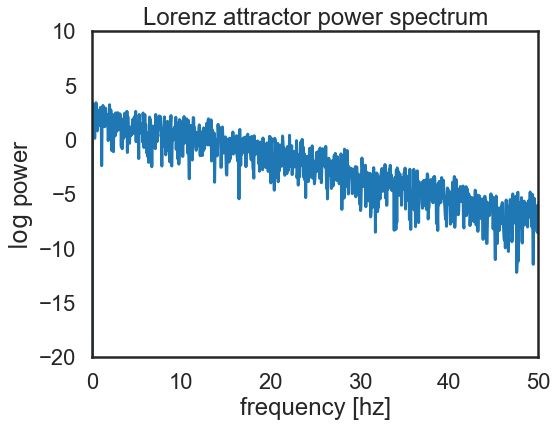

In [15]:
sns.set_context("poster",font_scale=1)
plt.figure(figsize=(8,6))
plt.plot(freq, np.log(Pxx_den))#np.abs(sp)**2)
plt.xlim([0, 50])
plt.ylim([-20,10])
plt.title("Lorenz attractor power spectrum")
plt.xlabel("frequency [hz]")
plt.ylabel("$\log$ power")
# plt.tight_layout()
plt.show()

In [16]:
# Numerical integrating a trajectory
# Choice of dt to ba a fractional value of the value found using the mutual information criterion
dt = 0.004 
num_steps =500
t_train = np.arange(0, num_steps, dt)
x0_train = [-8, 8, 27]
x_train = odeint(lorenz, x0_train, t_train)
x_dot_train_measured = np.array(
    [lorenz(x_train[i], 0) for i in range(t_train.size)]
)

adjustement=10
dt_adjusted=dt*adjustement
obs = x_train[::adjustement,:]
obs_x = obs[:,0]
obs_y = obs[:,1]
obs_z = obs[:,2]

## MI: optimal lag

Minima of delayed mutual information = [ 4 15 24 33 44 53 63 72 81 91]
Autocorrelation time = 8


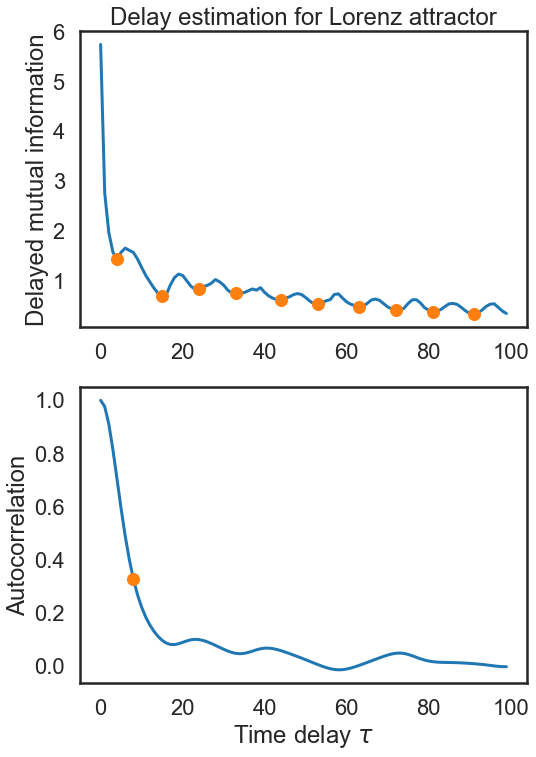

In [18]:
# Find optimal delay for geometric reconstruction of the attractor.
from nolitsa import delay, noise


def localmin(x):
    """Return all local minima from the given data set.
    Returns all local minima from the given data set.  Note that even
    "kinky" minima (which are probably not real minima) will be
    returned.
    Parameters
    ----------
    x : array
        1D scalar data set.
    Returns
    -------
    i : array
        Array containing location of all local minima.
    """
    return (np.diff(np.sign(np.diff(x))) > 0).nonzero()[0] + 1



# Compute autocorrelation and delayed mutual information.
lag = np.arange(100)
r = delay.acorr(obs_x, maxtau=100)
i = delay.dmi(obs_x, maxtau=100)

# While looking for local minima in the DMI curve, it's useful to do an
# SMA to remove "kinky" minima.
i_delay = localmin(noise.sma(i, hwin=1)) + 1
r_delay = np.argmax(r < 1.0 / np.e)

print(r'Minima of delayed mutual information = %s' % i_delay)
print(r'Autocorrelation time = %d' % r_delay)

plt.figure(1, figsize=(8,12))

plt.subplot(211)
plt.title(r'Delay estimation for Lorenz attractor')
plt.ylabel(r'Delayed mutual information')
plt.plot(lag, i, i_delay, i[i_delay], 'o')

plt.subplot(212)
plt.xlabel(r'Time delay $\tau$')
plt.ylabel(r'Autocorrelation')
plt.plot(lag, r, r_delay, r[r_delay], 'o')

if False:
    plt.figure(2)
    plt.subplot(121)
    plt.title(r'Time delay = %d' % i_delay[0])
    plt.xlabel(r'$x(t)$')
    plt.ylabel(r'$x(t + \tau)$')
    plt.plot(obs_x[:-i_delay[0]], obs_x[i_delay[0]:])

    plt.subplot(122)
    plt.title(r'Time delay = %d' % r_delay)
    plt.xlabel(r'$x(t)$')
    plt.ylabel(r'$x(t + \tau)$')
    plt.plot(obs_x[:-r_delay], obs_x[r_delay:])

plt.show()

## Finding the dimensionality

In [ ]:
# Find data dimensionality using FNN 
from nolitsa import dimension


dim = np.arange(1, 5 + 1)
delay=int(0.3/dt_adjusted)
f1, f2, f3 = dimension.fnn(obs_x[::delay], tau=1, dim=dim, window=10, metric='euclidean')

sns.set_context("poster")
plt.figure(figsize=(8,6))
plt.title(r'FNN for Lorenz partial observation $x$')
plt.xlabel(r'Embedding dimension $d$')
plt.ylabel(r'FNN (%)')
plt.plot(dim, 100 * f1, 'bo--', label=r'Test I')
plt.plot(dim, 100 * f2, 'g^--', label=r'Test II')
plt.plot(dim, 100 * f3, 'rs-', label=r'Test I + II', alpha=0.5)
plt.legend()

plt.show()

In [ ]:
sns.set_context("poster")
plt.figure(figsize=(8,6))
plt.plot(obs_x, obs_y, linewidth=1)
plt.title("Lorenz $x(t)-y(t)$")
plt.xlabel("$x(t)$")
plt.ylabel("$y(t)$")

In [ ]:
sns.set_context("poster")
plt.figure(figsize=(8,6))
delay=int(0.16/dt_adjusted)
plt.plot(obs_x[:-delay], obs_x[delay:], linewidth=0.1)
plt.title("Lorenz $x(t)-x(t+\delta)$")
plt.xlabel("$x(t)$")
plt.ylabel("$x(t+\delta)$")

In [ ]:
sns.set_context("poster")
plt.figure(figsize=(8,6))
delay=int(0.08/dt_adjusted)
plt.plot(obs_x[:-delay], obs_x[delay:], linewidth=1)
plt.title("Lorenz $x(t)-x(t+0.5\delta)$")
plt.xlabel("$x(t)$")
plt.ylabel("$x(t+\delta)$")